In [1]:
import sys
sys.path.insert(0, '/yunity/arusty/PF-GAP')

#Import libraries, MDS from SKlearn, and all the custom files
import pandas as pd
import matplotlib.pyplot as plt
from Pipeline.functions import *

#Functions
from QGAP.qgap import QGAP
from Redcomets.Redcomets import REDCOMETS
# from RFGAP_Rocket.RFGAP_Rocket import RFGAP_Rocket
# from RDST.rdst import RDST_GAP

In [2]:
static_data = pd.read_csv("/yunity/arusty/PF-GAP/data/sp500_fundamentals_combined.csv")
time_series = pd.read_csv("/yunity/arusty/PF-GAP/data/sp500_daily_returns_since_2022.csv")
stock_data = pd.read_csv("/yunity/arusty/PF-GAP/data/Labeled_11-01-2024_GICS.csv")

static_data.head()

,Ticker,Year,PE Ratio,PB Ratio,PS Ratio,ROE,ROA,Debt/Equity,Current Ratio,Profit Margin,Revenue Growth YoY,EPS Growth Next 5Y,Market Cap
0,MMM,2024,17.295145,16.742617,3.04910,1.086153,0.104670,312.492,1.657,0.169807,-0.010,0.221,74742579200
1,MMM,2023,17.295145,16.742617,3.04910,-1.455170,-0.138296,312.492,1.657,-0.284234,-0.010,0.221,74742579200
2,MMM,2022,17.295145,16.742617,3.04910,0.392406,0.124357,312.492,1.657,0.220825,-0.010,0.221,74742579200
3,AOS,2024,17.988981,5.003449,2.45474,0.283302,0.164691,12.132,1.552,0.139755,-0.077,-0.181,9372443648
4,AOS,2023,17.988981,5.003449,2.45474,0.301778,0.173185,12.132,1.552,0.144466,-0.077,-0.181,9372443648


In [3]:
# drop row with index 0 and reset index
time_series = time_series.drop(0).reset_index(drop=True).drop(columns=['Date']).dropna(axis=1).T

# show the first few rows
time_series.head()

,0,1,2,3,4,5,6,7,8,9,...,819,820,821,822,823,824,825,826,827,828
MMM,0.014010,-0.004106,-0.008301,0.010955,-0.014115,0.008850,0.002458,0.008917,-0.012595,-0.002574,...,-0.038678,0.022411,0.000441,-0.005514,-0.035487,-0.001916,-0.031641,0.081212,-0.001981,0.020726
AOS,0.016633,-0.016714,0.006703,-0.011296,-0.003127,0.009772,0.003345,-0.012384,-0.028575,0.001117,...,0.004955,0.025927,0.010853,-0.020705,-0.015505,0.004454,-0.022648,0.036461,-0.002345,0.023351
ABT,-0.023518,-0.004493,-0.000148,0.003108,-0.002213,0.003253,-0.014591,-0.027017,-0.011492,-0.012406,...,-0.019994,0.019116,0.008512,-0.009029,0.027571,0.009869,-0.008322,0.014166,-0.014348,-0.003543
ABBV,-0.001920,0.005253,-0.004711,-0.002588,0.011195,0.004252,0.002336,-0.017368,0.017600,0.006698,...,-0.031361,0.004879,0.023136,-0.003719,-0.028959,0.007631,-0.016359,0.021274,0.018817,0.018752
ACN,-0.007146,-0.017611,-0.048290,-0.019180,0.006069,0.005657,0.008152,-0.041942,-0.022166,-0.014376,...,-0.044361,-0.003085,0.019167,-0.003899,-0.011848,-0.010132,-0.011050,0.016939,0.014791,0.011278


In [4]:
stock_data.head(4)

,No.,Symbol,Company Name,Market Cap,Revenue,Sector,Labels
0,1,AAPL,Apple Inc.,"3,381.32B",391.04B,Technology,9
1,2,NVDA,NVIDIA Corporation,"3,328.48B",96.31B,Technology,9
2,3,MSFT,Microsoft Corporation,"3,060.49B",254.19B,Technology,9
3,4,GOOG,Alphabet Inc.,"2,103.30B",339.86B,Communication Services,0


In [5]:
# align sectors from stock_data to time_series rows and build labels list
# ensure there’s no leading/trailing whitespace in column names
stock_data.columns = stock_data.columns.str.strip()

sector_map = stock_data.set_index("Symbol")["Labels"]
labels = sector_map.reindex(time_series.index).tolist()
labels[:5]

[6.0, 6.0, 5.0, 5.0, 9.0]

In [6]:
labels =  pd.Categorical(labels).codes
np.unique(labels), len(labels) # NOTE: -1 is for missing values

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int8), 496)

In [7]:
labels

array([ 6,  6,  5,  5,  9,  9,  9, 10,  4,  5,  7,  1,  9,  7,  8,  5,  6,
       10,  4,  0,  0,  2,  1,  1, 10, 10,  4,  4,  8, 10,  4,  6,  5,  9,
        9,  9,  4,  3, -1,  9,  9,  1,  4,  2,  9,  4,  4,  0, 10,  9,  9,
        1,  8,  1,  6,  3,  1,  4,  5,  5,  4,  1,  5,  5,  4,  4,  4,  6,
        1,  5,  5,  9,  9,  4,  2,  6,  2,  8,  6,  9,  1,  8,  2,  4,  5,
        1,  1,  6,  6,  4,  8,  9,  5,  5, 10,  7,  5,  4,  0,  3,  1,  4,
        2,  5,  4,  6,  9,  4,  4,  2,  4, 10,  2,  9,  2,  0,  2,  3, 10,
        2,  5,  6,  9,  9,  7,  8,  2,  3,  9,  8,  6,  6,  5,  5,  1,  5,
        9,  1,  6,  9,  6,  3,  5,  3,  8,  4,  2,  2, 10,  1, -1,  6,  7,
        1, 10, 10,  7,  7,  6,  1,  7, 10,  5,  0,  5,  6,  9, 10,  3,  9,
        3,  6,  8,  8,  4,  8,  2,  4, 10, 10, 10, -1,  1,  6,  8,  3,  9,
        4,  9,  6,  8,  6,  9,  4,  9, 10,  9,  1,  9,  9,  0,  0,  4,  7,
        9,  9,  6,  9,  6,  6,  2,  1,  1,  5,  6,  4,  9,  4,  3,  4,  1,
        5,  8,  5,  2,  3

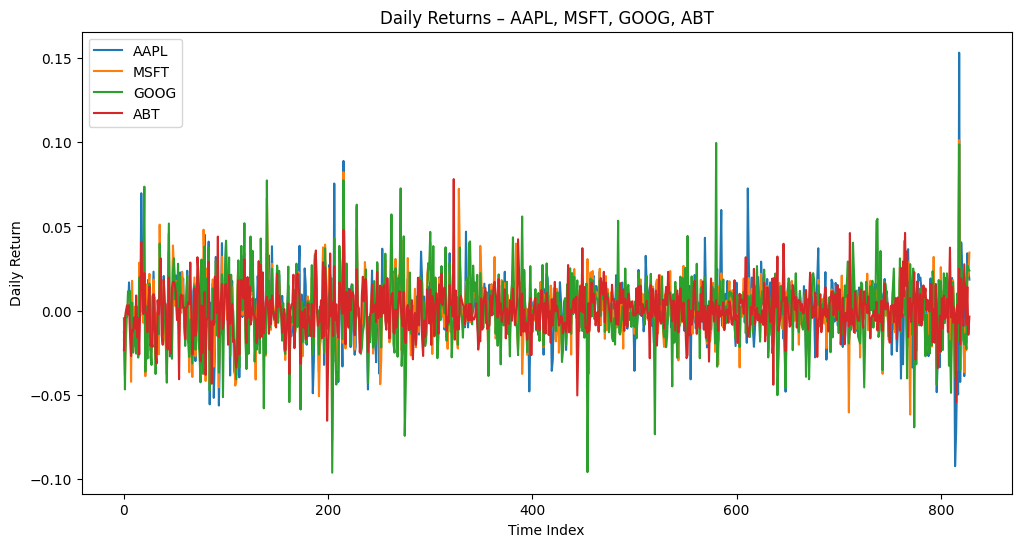

In [8]:
def plot_ticker_returns(tickers):
    # allow a single ticker string as input
    if isinstance(tickers, str):
        tickers = [tickers]
    # select the rows and transpose so time is on the x‐axis
    data = time_series.loc[tickers].T
    data.columns = tickers
    data.plot(figsize=(12, 6))
    plt.xlabel('Time Index')
    plt.ylabel('Daily Return')
    plt.title(f"Daily Returns – {', '.join(tickers)}")
    plt.legend()
    plt.show()

# example usage
plot_ticker_returns(['AAPL', 'MSFT', 'GOOG', 'ABT'])


# Creating the Proximities

In [9]:
from QGAP.qgap import QGAP
qgap = QGAP(matrix_type="dense")
quant_prox = data_to_proximities(qgap, time_series, labels, None, None, None)

In [10]:
redcomets = REDCOMETS(variant = 3) #static = XSTATIC
redcomets_prox = data_to_proximities(qgap, time_series, labels, None, None, None)

In [11]:
# Rocket
from RFGAP_Rocket.RFGAP_Rocket import RFGAP_Rocket

rf_rocket = RFGAP_Rocket(prediction_type = "classification", rocket = "Multi",
                         n_kernels=512) # Rocket Kwargs
rocket_prox = data_to_proximities(rf_rocket, time_series, labels, None, None , None)


In [ ]:
# # RDST
# from RDST.rdst import RDST_GAP
# rdst = RDST_GAP(save_transformed_data = True)
# rdst_prox = data_to_proximities(rdst, time_series, labels, None, None , None)

rdst_prox = np.load("rdst_prox.npy")


In [22]:
#NOTE: THIS TAKES FOREVER
# sys.path.insert(0, '/yunity/arusty/PF-GAP/PFGAP')
# from PFGAP.PyPFGAP import PyPFGAP
# pf = PyPFGAP()
# pf_prox = data_to_proximities(pf, time_series, labels.astype(str), None, None, None)

# Read in the file that took nearly 1.5 hours to run
pf_prox = np.load("pf_prox.npy")

# With Static

In [18]:
# Split static_data into separate DataFrames by year and align to time_series.index
for year in static_data['Year'].unique():
    # slice out this year's data
    df = static_data[static_data['Year'] == year].reset_index(drop=True)
    # reindex by ticker to match time_series rows
    df = df.set_index('Ticker').reindex(time_series.index).reset_index().drop(columns=['index', "Year"])

    # MEDIAN IMPUTATION... May change (but we have small amount of missing data )
    if df.isnull().values.any():
        df = df.fillna(df.median(numeric_only=True))


    globals()[f"static{year}"] = df
    print(f"static{year} aligned with time_series, shape {df.shape}")


static2024 aligned with time_series, shape (496, 11)
static2023 aligned with time_series, shape (496, 11)
static2022 aligned with time_series, shape (496, 11)
static2025 aligned with time_series, shape (496, 11)


In [26]:
static2022.sample(5) # Hass missing values?

,PE Ratio,PB Ratio,PS Ratio,ROE,ROA,Debt/Equity,Current Ratio,Profit Margin,Revenue Growth YoY,EPS Growth Next 5Y,Market Cap
402,41.619500,4.162670,6.712672,0.024840,0.015167,19.731,1.062,0.054507,0.076,0.195,2.543767e+11
418,16.738500,2.168946,1.109104,0.475093,0.272788,47.500,2.743,0.173519,-0.069,-0.608,1.909388e+10
70,23.597677,6.047696,2.051190,0.203696,0.065348,312.772,1.253,0.137070,0.075,-0.959,9.907246e+10
134,22.572073,10.654335,1.994227,0.433446,0.094003,357.830,0.386,0.098941,0.062,0.055,2.345669e+10
268,41.082855,4.790445,4.951872,0.270127,0.138800,38.944,2.953,0.207380,0.031,-0.010,2.484849e+10


In [16]:
time_series.head()

,0,1,2,3,4,5,6,7,8,9,...,819,820,821,822,823,824,825,826,827,828
MMM,0.014010,-0.004106,-0.008301,0.010955,-0.014115,0.008850,0.002458,0.008917,-0.012595,-0.002574,...,-0.038678,0.022411,0.000441,-0.005514,-0.035487,-0.001916,-0.031641,0.081212,-0.001981,0.020726
AOS,0.016633,-0.016714,0.006703,-0.011296,-0.003127,0.009772,0.003345,-0.012384,-0.028575,0.001117,...,0.004955,0.025927,0.010853,-0.020705,-0.015505,0.004454,-0.022648,0.036461,-0.002345,0.023351
ABT,-0.023518,-0.004493,-0.000148,0.003108,-0.002213,0.003253,-0.014591,-0.027017,-0.011492,-0.012406,...,-0.019994,0.019116,0.008512,-0.009029,0.027571,0.009869,-0.008322,0.014166,-0.014348,-0.003543
ABBV,-0.001920,0.005253,-0.004711,-0.002588,0.011195,0.004252,0.002336,-0.017368,0.017600,0.006698,...,-0.031361,0.004879,0.023136,-0.003719,-0.028959,0.007631,-0.016359,0.021274,0.018817,0.018752
ACN,-0.007146,-0.017611,-0.048290,-0.019180,0.006069,0.005657,0.008152,-0.041942,-0.022166,-0.014376,...,-0.044361,-0.003085,0.019167,-0.003899,-0.011848,-0.010132,-0.011050,0.016939,0.014791,0.011278


In [20]:
from QGAP.qgap import QGAP
qgap = QGAP(matrix_type="dense")
quant_prox = data_to_proximities(qgap, time_series, labels, None, static2024, None)

# Clustering the data

In [35]:
from sklearn.manifold import MDS
# Initialize MDS
def build_mds(prox):
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    symetric = (prox + prox.T) / 2
    mds_prox = mds.fit_transform(1- symetric)
    return mds_prox

# Build MDS for each method
mds_quant = build_mds(quant_prox)
mds_redcomets = build_mds( redcomets_prox)
mds_rocket = build_mds(rocket_prox)
mds_rdst = build_mds(rdst_prox)
mds_pf = build_mds(pf_prox)


In [37]:
np.unique(labels), len(labels) # NOTE: -1 is for missing values

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int8), 496)

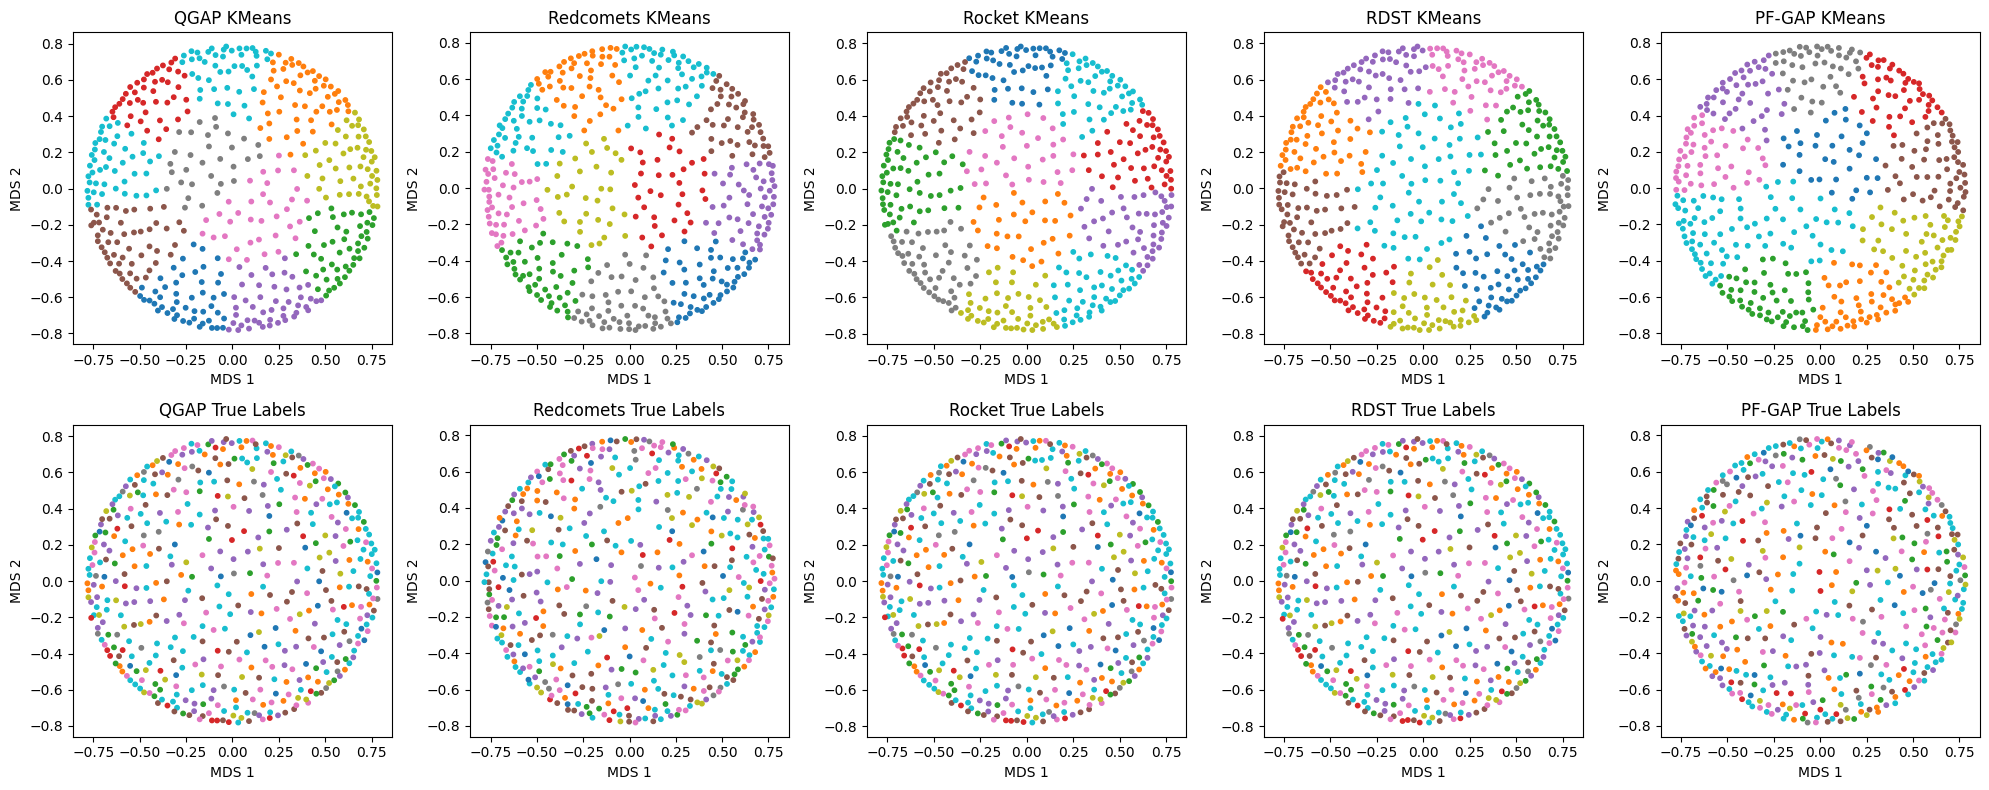

In [40]:
from sklearn.cluster import KMeans

mds_vars = {
    "QGAP": mds_quant,
    "Redcomets": mds_redcomets,
    "Rocket": mds_rocket,
    "RDST": mds_rdst,
    "PF-GAP": mds_pf
}

n_clusters = len(np.unique(labels[labels >= 0]))  # ignore -1 (missing)

fig, axes = plt.subplots(2, len(mds_vars), figsize=(20, 8), gridspec_kw={'height_ratios': [4, 4]})

for col, (name, mds_data) in enumerate(mds_vars.items()):
    # KMeans clustering plot (top row)
    ax = axes[0, col]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(mds_data)
    scatter = ax.scatter(mds_data[:, 0], mds_data[:, 1], c=clusters, cmap='tab10', s=10)
    ax.set_title(f"{name} KMeans")
    ax.set_xlabel("MDS 1")
    ax.set_ylabel("MDS 2")

    # True labels plot (bottom row)
    ax2 = axes[1, col]
    # Only plot points with valid labels
    valid = labels >= 0
    ax2.scatter(mds_data[valid, 0], mds_data[valid, 1], c=labels[valid], cmap='tab10', s=10)
    ax2.set_title(f"{name} True Labels")
    ax2.set_xlabel("MDS 1")
    ax2.set_ylabel("MDS 2")

plt.tight_layout()
plt.show()

# K-Fold Accuracy Tests

In [33]:
from sklearn.neighbors import KNeighborsClassifier

# Do five tests
n = len(time_series)

# Loop to do random tests
for i in range(6):
    # Use different subsets of the static data for training and testing
    if i < 2:
        static_train = static2022
        static_test = static2023
    elif i < 4:
        static_train = static2023
        static_test = static2024
    else:
        static_train = static2024
        static_test = static2025

    # Randomly select 80% of the data for training
    train_indices = np.random.choice(n, size=int(0.8 * n), replace=False)
    test_indices = np.setdiff1d(np.arange(n), train_indices)

    # Create the training and testing sets
    train_set = time_series.iloc[train_indices]
    test_set = time_series.iloc[test_indices]
    train_labels = labels[train_indices]
    test_labels = labels[test_indices]
    train_static = static_train.iloc[train_indices]
    test_static = static_test.iloc[test_indices]

    ### Test predictive accuracy of the model.... how? ###

    # Create the proximities for the training and testing sets
    quant_prox_train = data_to_proximities(qgap, train_set, train_labels, None, train_static, None)
    #quant_prox_test = data_to_proximities(qgap, test_set, test_labels, None, test_static, None)

    # Train a KNN model on the proximities
    knn = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    knn.fit(1 - quant_prox_train, train_labels)

    train_score = knn.score(1 -quant_prox_train, train_labels)
    print(f"Fold {i+1}: Train Accuracy = {train_score:.3f}, (Train size: {len(train_indices)})")


Fold 1: Train Accuracy = 1.000, (Train size: 396)
Fold 2: Train Accuracy = 1.000, (Train size: 396)
Fold 3: Train Accuracy = 0.997, (Train size: 396)
Fold 4: Train Accuracy = 1.000, (Train size: 396)
Fold 5: Train Accuracy = 1.000, (Train size: 396)
Fold 6: Train Accuracy = 1.000, (Train size: 396)
